In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from itertools import combinations
import itertools as itt

In [5]:
data = pd.read_csv("https://raw.githubusercontent.com/Sheisuka/BTC-Analytics/refs/heads/main/data/stage/btc.csv", parse_dates=["date"]).set_index("date")
data.head()

,open,close,high,low,volume,volume_usd
date,,,,,,
2013-01-02,13.355639,13.294495,13.423249,13.239912,20396.872342,271955.356139
2013-01-03,13.294495,13.425451,13.456261,13.268130,19832.397705,264748.290624
2013-01-04,13.425451,13.516544,13.523501,13.273098,35242.869825,473173.322612
2013-01-05,13.516544,13.442503,13.542806,13.300288,26589.448314,356979.562481
2013-01-06,13.442503,13.518296,13.528731,13.353631,15546.254699,209099.388365


In [6]:
data.describe()

,open,close,high,low,volume,volume_usd
count,4531.000000,4531.000000,4531.000000,4531.000000,4.531000e+03,4.531000e+03
mean,19378.466473,19401.771824,19823.487131,18915.284291,2.974293e+05,7.514750e+09
std,25299.284683,25330.060193,25821.846070,24765.760899,2.984588e+05,1.038947e+10
min,13.294495,13.294495,13.423249,13.239912,1.054983e+03,2.090994e+05
25%,597.956980,598.916689,608.320248,584.331943,6.686250e+04,2.550681e+07
50%,7954.649924,7960.659911,8237.678966,7689.995949,2.398905e+05,2.607672e+09
75%,29824.334489,29839.775316,30408.630125,29211.163290,3.944102e+05,1.279212e+10
max,111695.395496,111695.395496,111960.503548,109309.133852,3.137129e+06,1.047658e+11


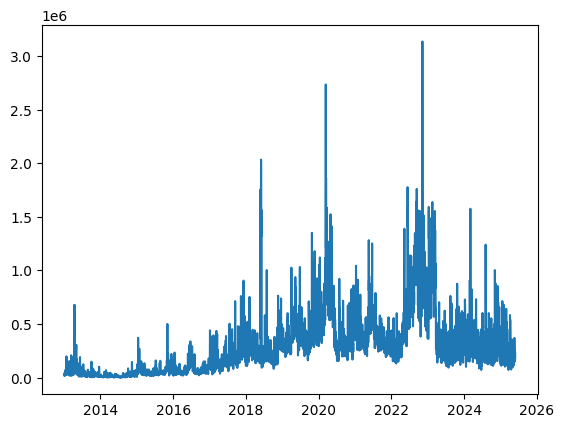

In [7]:
plt.plot(data.index, data["volume"])
plt.show()

In [8]:
%pip install hurst

<Axes: xlabel='date'>

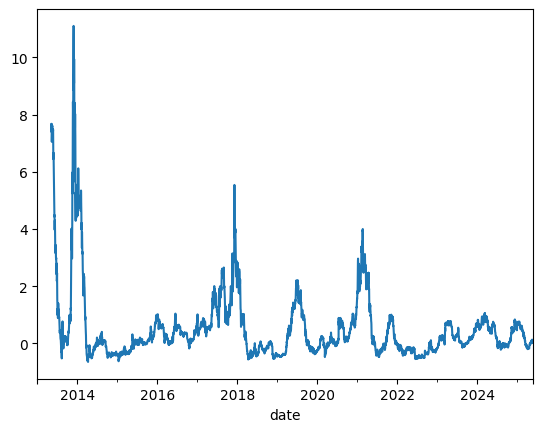

In [9]:
data['mom126'] = data['close'].pct_change(126)
data['mom126'].plot()

In [10]:
mask_pos = (data.mom126 >= 0.01)
data['signal_mh'] = np.where(mask_pos, 1, 0)
data['signal_mh'].value_counts()

,count
signal_mh,
1,2695
0,1836


/tmp/ipython-input-2253518319.py:1: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  data['returns'] = data.close.shift(-21).pct_change(21)


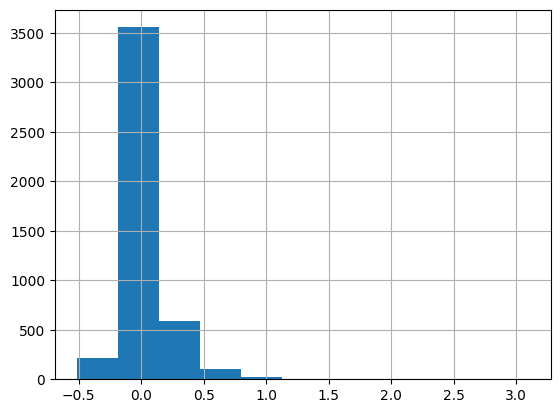

In [11]:
data['returns'] = data.close.shift(-21).pct_change(21)
data['strategy_returns'] = data['returns'].mul(data.signal_mh)
data['strategy_returns'].hist(bins=11)
data = data.dropna()

<Axes: xlabel='date'>

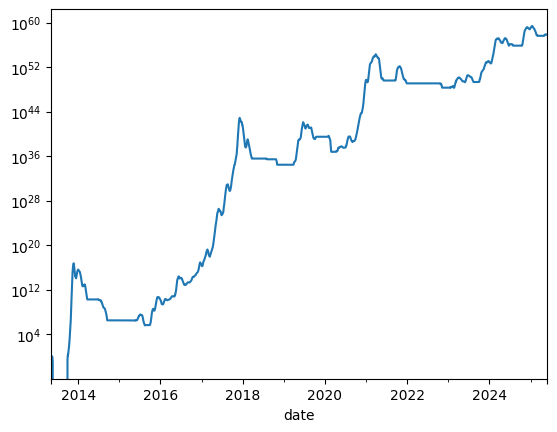

In [12]:
data['cumret'] = ((data['strategy_returns'] + 1.).cumprod() - 1)
data['cumret'].plot(logy=True)

In [13]:
!pip install pyfolio-reloaded

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 21.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 91.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 71.7 MB/s eta 0:00:00
  Created wheel for peewee: filename=peewee-3.17.3-py3-none-any.whl size=138487 sha256=9d2991294a80cd923b61bb9cab95f9341354a638c9aff4697d95843f3a6025d9
  Stored in directory: /root/.cache/pip/wheels/39/c7/dd/909d267742f7fbb941ff081dacd661f622a0b4eb38f667b84b
Successfully built peewee
  Attempting uninstall: peewee
    Found existing installation: peewee 3.18.2
    Uninstalling peewee-3.18.2:
      Successfully uninstalled peewee-3.18.2


In [14]:

import pyfolio as pf
perf_func = pf.timeseries.perf_stats
perf_func(data['strategy_returns'])

/usr/local/lib/python3.12/dist-packages/pyfolio/pos.py:25: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(


,0
Annual return,2.019327e+03
Cumulative returns,6.015853e+57
Annual volatility,3.682215e+00
Sharpe ratio,3.292702e+00
Calmar ratio,2.019327e+03
Stability,9.128380e-01
Max drawdown,-1.000000e+00
Omega ratio,2.662249e+00
Sortino ratio,1.034404e+01
Skew,5.500282e+00


In [15]:
def cpcv_generator(t_span, n, k):
    # 1. разбиваем моменты времени на n групп
    group_num = np.arange(t_span) // (t_span // n)
    group_num[group_num == n] = n-1

    # 2. считаем количество всевозможных симуляций и путей
    test_groups = np.array(list(itt.combinations(np.arange(n), k))).reshape(-1, k)
    C_nk = len(test_groups)
    n_paths = C_nk * k // n

    # 3. отмечаем моменты времени и группы как тестовые
    is_test_group = np.full((n, C_nk), fill_value=False)
    is_test = np.full((t_span, C_nk), fill_value=False)

    for sim_i, comb in enumerate(test_groups):
        is_test_group[comb, sim_i] = True # группа тестовая в симуляции sim_i

        mask = np.isin(group_num, comb)
        is_test[mask, sim_i] = True

    # 4. для каждого пути отмечаем из каких групп он состоит
    path_folds = np.full((n, n_paths), fill_value=np.nan) # всемозможные пути тестирования

    # для каждой группы находим симуляцию с минимальным номером,
    # в которой она тестовая
    for i in range(n_paths):
        for j in range(n):
            sim_i = is_test_group[j, :].argmax().astype(int)
            path_folds[j, i] = sim_i
            is_test_group[j, sim_i] = False

    # 5. для каждого пути отмечаем из каких моментов времени он состоит
    paths = np.full((t_span, n_paths), fill_value=np.nan)

    for p in range(n_paths):
        for i in range(n):
            mask = (group_num == i)
            paths[mask, p] = int(path_folds[i, p])

    return (is_test, paths, path_folds)


In [20]:
num_ticks = 100
num_paths = 5
num_groups_test = 2
num_groups = num_paths + 1

is_test, paths, path_folds = cpcv_generator(num_ticks, num_groups, num_groups_test)
path_folds

array([[ 0.,  1.,  2.,  3.,  4.],
       [ 0.,  5.,  6.,  7.,  8.],
       [ 1.,  5.,  9., 10., 11.],
       [ 2.,  6.,  9., 12., 13.],
       [ 3.,  7., 10., 12., 14.],
       [ 4.,  8., 11., 13., 14.]])

In [22]:
from hurst import compute_Hc
data['hurst'] = data['close'].rolling(window=126).apply(lambda x: compute_Hc(x)[0])
data['hurst'].isna().sum() / len(data)

np.float64(0.028376844494892167)

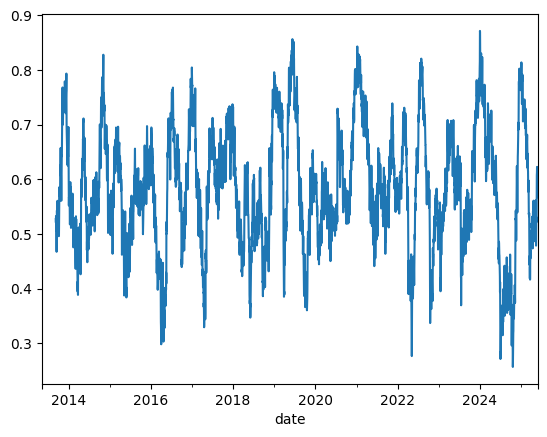

In [24]:
data['hurst'].plot()
plt.show()

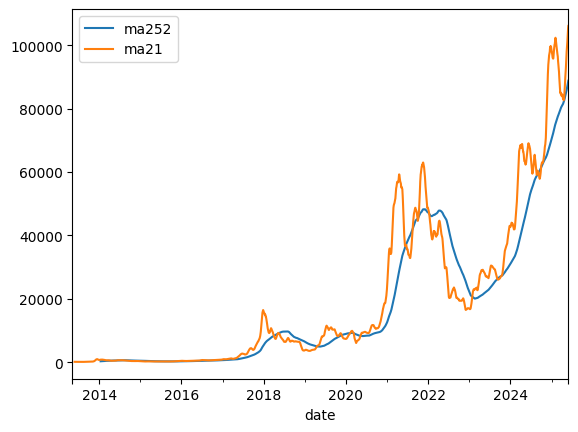

In [25]:
data['zscore'] = (data.close - data.close.rolling(126).mean()) / data.close.rolling(126).std()
data['ma21'] = data.close.rolling(21).mean()
data['ma252'] = data.close.rolling(252).mean()
data['vol'] = data.close.pct_change().rolling(63).std()
data[['ma252', 'ma21']].plot()
plt.show()

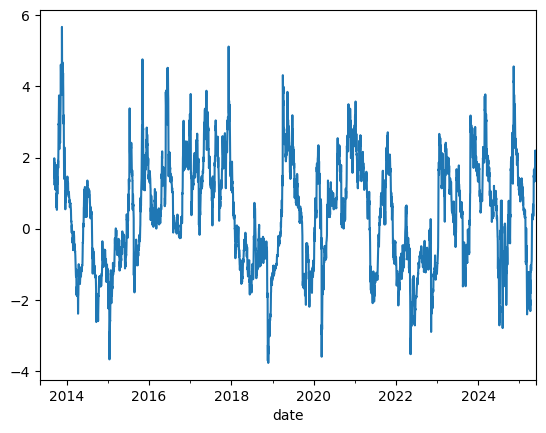

In [26]:
data['zscore'].plot()
plt.show()

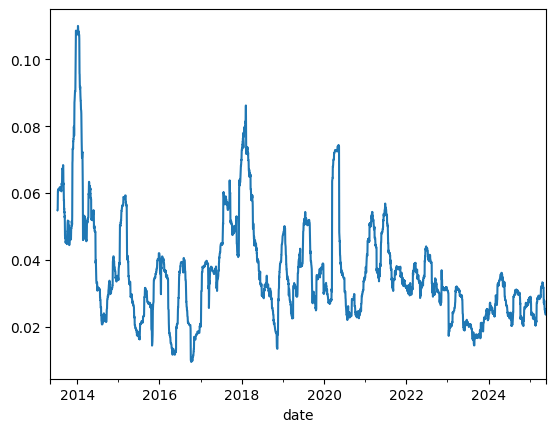

In [27]:
data['vol'].plot()
plt.show()

In [28]:
feats = ['zscore', 'ma252', 'ma21', 'vol', 'hurst']
data[feats].corr()

,zscore,ma252,ma21,vol,hurst
zscore,1.000000,-0.096693,0.022897,-0.029561,0.312500
ma252,-0.096693,1.000000,0.951135,-0.210468,-0.050838
ma21,0.022897,0.951135,1.000000,-0.226774,0.037450
vol,-0.029561,-0.210468,-0.226774,1.000000,0.173075
hurst,0.312500,-0.050838,0.037450,0.173075,1.000000


In [29]:
from tqdm.notebook import tqdm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

In [31]:
t1_ = data.index
t1 = pd.Series(t1_[21:], index=t1_[:-21])
t1.head()

,date
date,
2013-05-08,2013-05-29
2013-05-09,2013-05-30
2013-05-10,2013-05-31
2013-05-11,2013-06-01
2013-05-12,2013-06-02


In [50]:
def purge(t1, test_times):
    train = t1.copy(deep=True)
    for start, end in test_times.items():
        df_0 = train[(start <= train.index) & (train.index <= end)].index
        df_1 = train[(start <= train) & (train <= end)].index
        df_2 = train[(train.index <= start) & (end <= train)].index
        train = train.drop(df_0.union(df_1).union(df_2))
    return train

In [51]:
def embargo_(times, pct_embargo):
    step = int(times.shape[0] * pct_embargo)
    if step == 0:
        return pd.Series(times, index=times)
    ans = pd.Series(times[step:].values, index=times[:-step].index)
    ans = pd.concat([ans,pd.Series(times[-1], index=times[-step:].index)])
    return ans

def embargo(test_times, t1, pct_embargo=0.01):
    t1_embargo = embargo_(t1, pct_embargo)
    test_times_embargoed = t1_embargo.loc[test_times.index]
    return test_times_embargoed


In [35]:
data.shape

(4405, 16)

In [39]:
thold = 0.01
returns = data.close.shift(-21).pct_change(21)
signal = data.signal_mh

mask_1 = (returns > thold) & (signal == 1)
mask_2 = (returns > thold) & (signal == 0)
mask_3 = (returns <= thold) & (signal == 1)
mask_4 = (returns <= thold) & (signal == 0)

data['y'] = np.nan
data.loc[mask_1, 'y'] = 1
data.loc[mask_2, 'y'] = 0
data.loc[mask_3, 'y'] = 0
data.loc[mask_4, 'y'] = 1

data['y'].value_counts()

/tmp/ipython-input-135168267.py:2: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = data.close.shift(-21).pct_change(21)


,count
y,
1.0,2330
0.0,2054


In [40]:
data = data.loc[t1.index]
len(data), len(t1)

(4384, 4384)

In [41]:
data = data.dropna()
t1 = t1.loc[data.index]
len(t1)

4133

In [42]:
num_paths = 5
num_groups_test = 2
num_groups = num_paths + 1
num_ticks = len(data)

is_test, paths, _ = cpcv_generator(num_ticks, num_groups, num_groups_test)

In [57]:
pred = np.full(is_test.shape, np.nan)

X = data[feats]
y = data['y']

num_sim = is_test.shape[1]
for k in tqdm(range(num_sim)):
    test_idx = is_test[:, k]
    test_times = t1.loc[test_idx]
    test_times_embargoed = embargo(test_times, t1, pct_embargo=0.01)
    train_times = purge(t1, test_times_embargoed)

    X_test = X.loc[test_times.index, :]
    y_test = y.loc[X_test.index]

    X_train = X.loc[train_times.index, :]
    y_train = y.loc[X_train.index]

    print('training classifier for simulation %s' % k)

    np.random.seed(42)
    base_est = DecisionTreeClassifier(
        criterion='entropy',
        max_features=20,
        class_weight='balanced',
        min_weight_fraction_leaf=0.05
    )
    clf = BaggingClassifier(
        estimator=base_est,
        n_estimators=50,
        max_features=.99
    )

    clf.fit(X_train, y_train)
    pred_ = clf.predict(X_test)

    pred[test_idx, k] = pred_

  0%|          | 0/15 [00:00<?, ?it/s]

/tmp/ipython-input-2246050053.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ans = pd.concat([ans,pd.Series(times[-1], index=times[-step:].index)])


training classifier for simulation 0


/tmp/ipython-input-2246050053.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ans = pd.concat([ans,pd.Series(times[-1], index=times[-step:].index)])


training classifier for simulation 1


/tmp/ipython-input-2246050053.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ans = pd.concat([ans,pd.Series(times[-1], index=times[-step:].index)])


training classifier for simulation 2


/tmp/ipython-input-2246050053.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ans = pd.concat([ans,pd.Series(times[-1], index=times[-step:].index)])


training classifier for simulation 3


/tmp/ipython-input-2246050053.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ans = pd.concat([ans,pd.Series(times[-1], index=times[-step:].index)])


training classifier for simulation 4


/tmp/ipython-input-2246050053.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ans = pd.concat([ans,pd.Series(times[-1], index=times[-step:].index)])


training classifier for simulation 5


/tmp/ipython-input-2246050053.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ans = pd.concat([ans,pd.Series(times[-1], index=times[-step:].index)])


training classifier for simulation 6


/tmp/ipython-input-2246050053.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ans = pd.concat([ans,pd.Series(times[-1], index=times[-step:].index)])


training classifier for simulation 7


/tmp/ipython-input-2246050053.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ans = pd.concat([ans,pd.Series(times[-1], index=times[-step:].index)])


training classifier for simulation 8


/tmp/ipython-input-2246050053.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ans = pd.concat([ans,pd.Series(times[-1], index=times[-step:].index)])


training classifier for simulation 9


/tmp/ipython-input-2246050053.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ans = pd.concat([ans,pd.Series(times[-1], index=times[-step:].index)])


training classifier for simulation 10


/tmp/ipython-input-2246050053.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ans = pd.concat([ans,pd.Series(times[-1], index=times[-step:].index)])


training classifier for simulation 11


/tmp/ipython-input-2246050053.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ans = pd.concat([ans,pd.Series(times[-1], index=times[-step:].index)])


training classifier for simulation 12


/tmp/ipython-input-2246050053.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ans = pd.concat([ans,pd.Series(times[-1], index=times[-step:].index)])


training classifier for simulation 13


/tmp/ipython-input-2246050053.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ans = pd.concat([ans,pd.Series(times[-1], index=times[-step:].index)])


training classifier for simulation 14


In [59]:
backtest_paths = np.full((X.shape[0], paths.shape[1]), np.nan)
old_signal = data['signal_mh'].loc[X.index]
ret = data['returns'].loc[X.index]

for p in range(paths.shape[1]):
    for t, k in enumerate(paths[:, p]):
        backtest_paths[t, p] = (bool(pred[t, int(k)]) & bool(old_signal[t])) * ret[t]

perf_list = []
for s in range(paths.shape[1]):
    perf_table = perf_func(backtest_paths[:, s])
    perf_list.append(perf_table)

perf_paths = pd.concat(perf_list, axis=1)
perf_paths

/tmp/ipython-input-2866909641.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  backtest_paths[t, p] = (bool(pred[t, int(k)]) & bool(old_signal[t])) * ret[t]


,0,1,2,3,4
Annual return,8.284984e+00,1.676431e+00,6.390893e+01,7.442615e+00,2.462217e+00
Cumulative returns,7.453825e+15,1.028628e+07,5.287268e+29,1.566599e+15,7.011943e+08
Annual volatility,1.752275e+00,1.795178e+00,2.327340e+00,2.002202e+00,2.097464e+00
Sharpe ratio,2.047069e+00,1.356378e+00,2.795711e+00,1.945367e+00,1.489158e+00
Calmar ratio,8.284984e+00,1.676431e+00,6.390893e+01,7.442615e+00,2.462217e+00
Stability,8.842492e-01,5.566906e-01,9.339851e-01,8.511785e-01,6.171223e-01
Max drawdown,-1.000000e+00,-1.000000e+00,-1.000000e+00,-9.999999e-01,-1.000000e+00
Omega ratio,2.066740e+00,1.573067e+00,2.272186e+00,1.847549e+00,1.572004e+00
Sortino ratio,4.337597e+00,2.589671e+00,6.401754e+00,4.055324e+00,3.078094e+00
Skew,2.639464e+00,2.384816e+00,2.405533e+00,2.430901e+00,2.857446e+00


In [61]:
perf_paths.loc['Sharpe ratio', :].mean()

np.float64(1.926736685090706)

In [62]:
perf_paths.loc['Sharpe ratio', :].std()

0.5671700300614335

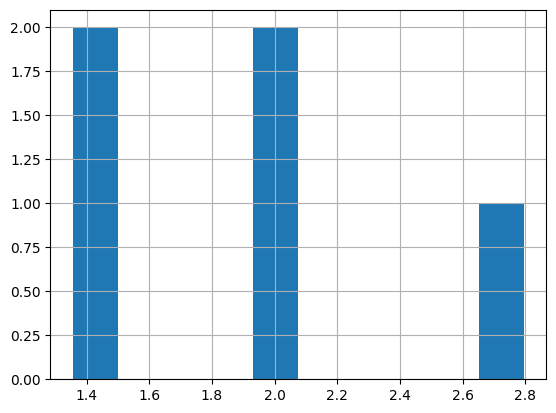

In [63]:
perf_paths.loc['Sharpe ratio', :].hist()
plt.show()

In [64]:
perf_paths.loc['Max drawdown', :].mean()

np.float64(-0.9999999830406171)

In [65]:
perf_paths.loc['Max drawdown', :].std()

2.6585037450382636e-08

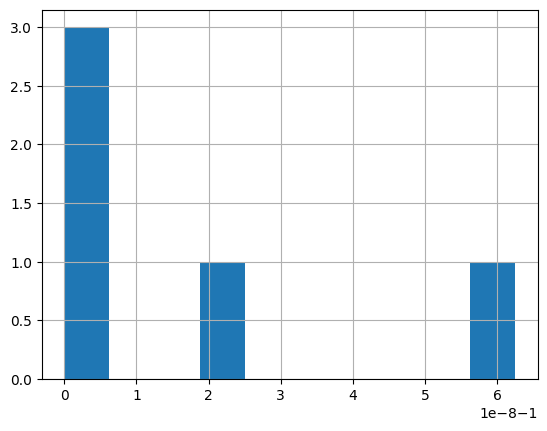

In [66]:
perf_paths.loc['Max drawdown', :].hist()
plt.show()